# CS-6570 Lecture 10 - Hyperparameter Tuning

**Dylan Zwick**

*Weber State University*

At the end of our last lecture, I introduced two biased models used to minimize overfitting for regression models: *ridge* regression and *lasso* regression. Today, we'll dive into those approaches in more detail - focusing mostly on how we determine, or "tune", the value of $\lambda$.

But first, let's load up our favorite libraries.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Next, let's grab the "Credit.csv" data again:

In [6]:
credit = pd.read_csv('Credit.csv')

And let's specify our predictors and target:

In [8]:
#Define the variables we'll be using for predictions.
predictors = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own', 'Student', 'Married']
#Define the variable we'll be predicting.
target = 'Balance'

#Translate the Yes/No variables into binary 1/0 variables.
credit['Own'] = credit['Own'].map({'No':0,'Yes':1})
credit['Student'] = credit['Student'].map({'No':0,'Yes':1})
credit['Married'] = credit['Married'].map({'No':0,'Yes':1})

#Initialization variables
y = credit[target]
X = credit[predictors]

For _ridge regression_, the measure we attempt to minimize is:

&nbsp;
<center>
    $\displaystyle \sum_{i = 1}^{n}\left(y_{i} - \hat{y}_{i}\right)^{2} + \lambda \sum_{j = 1}^{p}\beta_{j}^{2}$.
</center>
&nbsp;

For _lasso regression_, the model we attempt to minimize is:

&nbsp;
<center>
    $\displaystyle \sum_{i = 1}^{n}\left(y_{i} - \hat{y}_{i}\right)^{2} + \lambda \sum_{j = 1}^{p}|\beta_{j}|$.
</center>
&nbsp;

Both models penalize large values of the coefficients, and so are biased towards $0$. This means the approach will tend to favor underestimating the coefficients. 

Why would we want to do this? Well, if we recall from our first lecture, generally speaking the introduction of bias tends to decrease the variance within our model (the bias-variance tradeoff), and so by decreasing the variance, you decrease the chance that your model will be far removed from the actual "correct" model.

We call the penalty for Ridge regression an $\ell_{2}$ norm, and the penalty for the Lasso is $\ell_{1}$ norm. The different numbers refer to the exponent of the individual $\beta_{i}$ terms. (Note technically to be an $\ell_{2}$ norm, the penalty for ridge regression should have a square root, but don't worry about that here.)

Now, one of the first thing to notice here is that term $\lambda$. What is it, and how do we know its value? Well, the term $\lambda$ is something called a _hyperparameter_. You don't determine it as part of the modeling process - you define it before you start the modeling process. So, you could view both ridge and lasso regression not as single models, but as families of models parametrized by $\lambda$.

At one extreme, $\lambda = 0$, both ridge and lasso regression reduce to standard regression, in which the goal is to minimize $\sum_{i = 1}^{n}\left(y_{i} - \hat{y}_{i}\right)^{2}$. On the other extreme, as $\lambda \rightarrow \infty$, the penalty for any positive coefficient goes to $\infty$, and so the model will tend towards a constant model $Y = \beta_{0}$, where $\beta_{0}$ will just be the average of the output values.

It is between these extremes that we want to build our model, and so how do we figure out $\lambda$? Well, as usual, if we just try to optimize a value like $RSS$ on our training data, we won't get anywhere. Specifically, we'll always choose $\lambda = 0$ by definition.

One way we could try to determine the optimal value of $\lambda$ is with a *validation set*. The idea behind a validation set is that you leave out some portion of your data, say 20%, and then you build your model(s) using the remaining 80%. You then test how those various models do on the data in the validation set, and you pick the model that does the best.

The validation set approach is conceptually simple and easy to implement. However, it has two potential drawbacks:

1. The validation estimate of the test error rate can be highly variable, and can be highly dependent on precisely which observations are included in the training set vs. the validation set.


2. Only a subset of the observations, those that are included in the training set, are used to fit the model. Since statistical methods tend to perform worse when trained on fewer observations, this suggests that the validation set error rate may _overestimate_ the test error rate for the model when fit on the entire data set.

One way to, partially, address these concerns is by using _cross-validation_, a refinement of the validation set approach that addresses these two issues.

**Leave-One-Out Cross-Valdation (LOOCV)**

For LOOCV, instead of creating two subsets of comparable size as in the validation set approach, a single observation $(x_{i},y_{i})$ is used for the validation set, and the remaining observations make up the training set. The model is then fit on the $n-1$ training observations, and its predicted value $\hat{y}_{i}$ for $x_{i}$ is tested against the actual output $y_{i}$. So, $MSE_{i} = (y_{i}-\hat{y}_{i})^{2}$. This procedure is repeated for all $n$ observations, and the estimated $MSE$ is the average of the errors for each model:

&nbsp;
<center>
    $\displaystyle CV_{(n)} = \frac{1}{n}\sum_{i = 1}^{n}MSE_{i}$.
</center>
&nbsp;

This approach has far less bias than the validation set approach, and removes the randomness and risk inherent in the training / validation set splits. However, it can be computationally expensive.

**k-Fold Cross-Validation**

An alternative to LOOCV is $k$-fold cross-validation (CV). In this approach, we randomly divide the set of observations into $k$ groups, or _folds_, of approximately equal size. The first fold is treated as the validation set, and the model is fit on the remaining $k-1$ folds. The mean squared error of the model on this first fold, $MSE_{1}$, in then computed. Thes is repeated $k$ times, producing $MSE_{1},MSE_{2},\ldots,MSE_{k}$. The $MSE$ estimate is then computed as:

&nbsp;
<center>
    $\displaystyle CV_{(k)} = \frac{1}{k}\sum_{i = 1}^{n}MSE_{i}$.
</center>
&nbsp;

It isn't hard to see that the validation set approach and LOOCV are just special cases of $k$-fold CV, with $k = 2$ and $k = n$ respectively. Which value of $k$ should you use for your model? Well, that's another hyperparameter.

The problem with using a large value of $k$ isn't just the increase in computation time, which for modern computers is rarely a huge concern. Yet again, the problem with using a large value for $k$ is the bias-variance trade-off. For the extreme case of LOOCV, the training data for each model is almost exactly the same, which means the models are highly correlated. This means that, while a larger value of $k$ will decrease the bias in the individual estimates (the tendency to overestimate the error), it will also increase the variance. There's basically no way of getting out of that tradeoff.

We'll talk more about cross-validation in the context of resambling methods next week, but for now let's take a look at how we might calculate $\lambda$ for ridge or lasso regression using cross-validation in Python.

First, we'll import some modules from sklearn that we'll want for Ridge and Lasso regression, along with cross-validation:

In [20]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split

We'll also be calculating the mean square error of some outputs, so let's grab the function for doing that as well.

In [22]:
from sklearn.metrics import mean_squared_error

Next, I'll create a set of potential lambdas over a wide range of values. Specifically, I'll create 90 potential $\lambda$ values ranging from $10^{7}$ to $10^{-2}$, with even spacing between the _exponents_.

In [24]:
lambdas = 10**np.linspace(7,-2,90)
lambdas

array([1.00000000e+07, 7.92275825e+06, 6.27700983e+06, 4.97312315e+06,
       3.94008524e+06, 3.12163429e+06, 2.47319538e+06, 1.95945291e+06,
       1.55242717e+06, 1.22995052e+06, 9.74460063e+05, 7.72041151e+05,
       6.11669540e+05, 4.84610990e+05, 3.83945572e+05, 3.04190795e+05,
       2.41003013e+05, 1.90940861e+05, 1.51277828e+05, 1.19853766e+05,
       9.49572415e+04, 7.52323269e+04, 5.96047539e+04, 4.72234056e+04,
       3.74139626e+04, 2.96421781e+04, 2.34847811e+04, 1.86064243e+04,
       1.47414202e+04, 1.16792709e+04, 9.25320396e+03, 7.33108980e+03,
       5.80824522e+03, 4.60173228e+03, 3.64584124e+03, 2.88851187e+03,
       2.28849813e+03, 1.81312174e+03, 1.43649253e+03, 1.13809830e+03,
       9.01687771e+02, 7.14385423e+02, 5.65990301e+02, 4.48420433e+02,
       3.55272668e+02, 2.81473946e+02, 2.23005003e+02, 1.76681473e+02,
       1.39980460e+02, 1.10903134e+02, 8.78658723e+01, 6.96140065e+01,
       5.51534944e+01, 4.36967803e+01, 3.46199027e+01, 2.74285120e+01,
      

Cool. Alright, now I'll set up my output and input values.

Alright, now we're going to do a bunch of ridge regressions, and record the coefficients we get. Note, there's no concensus as to whether the hyperparameter for ridge or lasso regression is a $\lambda$ or an $\alpha$. Most of the teaching literature uses $\lambda$, so I've used it here. Unfortunately, Python uses $\alpha$, which you'll see in the code below.

In [27]:
ridge = Ridge()
coefs = [] #Keep track of the coefficients.

for l in lambdas:
    ridge.set_params(alpha = l) #Ridge regression in Python calls the lambda term alpha.
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

Each of the 90 models should have nine coefficients, so let's check to make sure that's true.

In [29]:
np.shape(coefs)

(90, 9)

Now, let's take a look at how these coefficients change as the value of $\lambda$ (the penalty) increases.

Text(0, 0.5, 'weights')

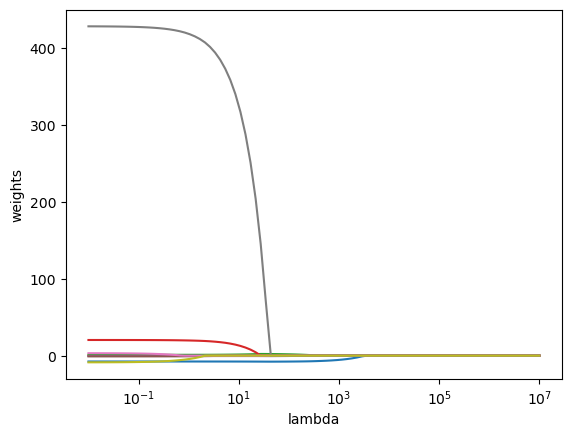

In [86]:
ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('weights')

OK. Let's use sklearn's train_test_split to create a validation set, and check out some coefficients for different values of $\lambda$.

In [33]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

For the smaller value of $\lambda = 10^{-1} = .1$:

In [35]:
ridge2 = Ridge(alpha = 1)# Again, Python uses alpha and not lambda, sorry
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

Income        -7.630106
Limit          0.194519
Rating         1.089936
Cards         20.267416
Age           -0.588028
Education     -0.700885
Own            3.574424
Student      407.294136
Married       -9.705093
dtype: float64
9980.59519379909


For the larger value of $\lambda = 10^{7} = 10,000,000$:

In [37]:
ridge3 = Ridge(alpha = 10**7)
ridge3.fit(X_train, y_train)             
pred3 = ridge3.predict(X_test)           
print(pd.Series(ridge3.coef_, index = X.columns)) 
print(mean_squared_error(y_test, pred3))          

Income      -0.063776
Limit        0.166727
Rating       0.016809
Cards        0.000909
Age         -0.014565
Education    0.000383
Own          0.000106
Student      0.000878
Married     -0.000174
dtype: float64
53148.89603739644


And for the standard linear regression situation $\lambda = 0$:

In [39]:
ridge4 = Ridge(alpha = 0)
ridge4.fit(X_train, y_train)             
pred4 = ridge4.predict(X_test)            
print(pd.Series(ridge4.coef_, index = X.columns)) 
print(mean_squared_error(y_test, pred4))           

Income        -7.620455
Limit          0.196122
Rating         1.067382
Cards         20.367600
Age           -0.565695
Education     -0.915714
Own            3.185341
Student      428.677306
Married       -8.748533
dtype: float64
9986.129099705022


So, $\lambda = 10^{-1}$ is a bit better than $\lambda = 0$, but not much.

For ridge regression there is already a function, RidgeCV, that will select the best value of $\lambda$ using cross-validation. The value of the parameter "cv" sets the number of folds, and it defaults to LOOCV.

In [42]:
ridgecv = RidgeCV(alphas = lambdas)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.10262093211115313

Building a ridge regression model with the optimal $\lambda$ from above, we get:

In [44]:
ridge5 = Ridge(alpha = ridgecv.alpha_)
ridge5.fit(X_train, y_train)
mean_squared_error(y_test, ridge5.predict(X_test))

9981.892242529902

With coefficients:

In [88]:
ridge5.fit(X, y)
pd.Series(ridge5.coef_, index = X.columns)

Income        -7.801234
Limit          0.192841
Rating         1.105669
Cards         17.899564
Age           -0.635626
Education     -1.105129
Own          -10.353610
Student      425.223052
Married       -7.084214
dtype: float64

With cv = 10 we get:

In [90]:
ridgecv = RidgeCV(alphas = lambdas, cv = 10)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.16348697045064184

In [92]:
ridge6 = Ridge(alpha = ridgecv.alpha_)
ridge6.fit(X_train, y_train)
mean_squared_error(y_test, ridge6.predict(X_test))

9979.810283611805

_Slightly_ better.

In [94]:
ridge6.fit(X, y)
pd.Series(ridge6.coef_, index = X.columns)

Income        -7.800781
Limit          0.192702
Rating         1.107676
Cards         17.885564
Age           -0.636186
Education     -1.099286
Own          -10.322321
Student      424.487397
Married       -7.122565
dtype: float64

Note that, while many of these coefficients are small, _none_ are $0$. That will not be the case with lasso regression.

Note that for lasso regression here, it figures out the optimal value using iterative fitting, and we need to specify a maximum number of required iterations. We won't get into why it's different than ridge regression, but it has to do with optimizing squared terms vs. optimizing absolute values - smooth derivatives and all that.

Text(0, 0.5, 'weights')

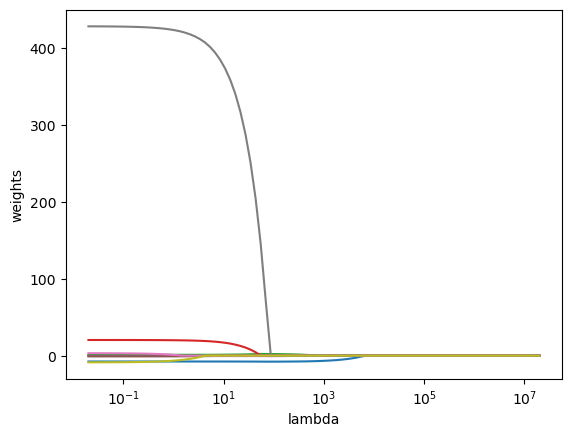

In [96]:
lasso = Lasso(max_iter = 100000)
coefs = []

for l in lambdas:
    lasso.set_params(alpha=l)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(lambdas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('weights')

In [98]:
lassocv = LassoCV(alphas = lambdas, max_iter = 100000)
lassocv.fit(X_train, y_train)

print(lassocv.alpha_)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

1.0531055707361898


9921.059317086045

In [100]:
pd.Series(lasso.coef_, index=X.columns)

Income        -7.637751
Limit          0.194561
Rating         1.090534
Cards         19.696133
Age           -0.542100
Education     -0.760594
Own            0.000000
Student      418.286555
Married       -4.277255
dtype: float64

The lasso here does a bit better than ridge, and we can see it sets one value, Own, to $0$.

What about for larger values of $\lambda$? Well, here we see that lasso sets many coefficients to $0$.

In [59]:
lasso2 = Lasso(alpha = 10**3, max_iter = 100000)
lasso2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred5 = lasso2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(lasso2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred5))          # Calculate the test MSE

Income      -5.547870
Limit        0.235315
Rating       0.000000
Cards        0.000000
Age         -0.000000
Education    0.000000
Own          0.000000
Student      0.000000
Married     -0.000000
dtype: float64
27485.90270833892


As expected, most of the coefficients are $0$, which is not what we saw for large values of $\lambda$ in ridge regression.